In [1]:
import os
from tqdm import tnrange, tqdm_notebook, tqdm
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid
import torchnlp.nn as nnnlp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

%matplotlib inline

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
torch.cuda.is_available()

True

In [6]:
batch_size = 32
num_epochs = 1000

z_dimension = 100
num_feature_x1 = 96 # 192
num_feature_x2 = 96 # 192

In [7]:
# device_ids = [0, 1]

In [8]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

dataset = datasets.ImageFolder('~/data/anime-faces', transform=img_transform) # ./datas/faces
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [9]:
class SelfAttention(nn.Module):
    """ Self attention Layer"""
    def __init__(self,in_dim):
        super(SelfAttention,self).__init__()
        self.chanel_in = in_dim
        
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))

        self.softmax  = nn.Softmax(dim=-1) #
        
    def forward(self, x):
        
        m_batchsize, C, width ,height = x.size()
        proj_query = self.query_conv(x).view(m_batchsize, -1, width * height).permute(0, 2, 1) # B (N) C
        proj_key = self.key_conv(x).view(m_batchsize, -1, width * height) # B C (N)
        
#         energy = torch.bmm(proj_query, proj_key) # transpose check
        energy = torch.bmm(proj_query.cpu(), proj_key.cpu()) # transpose check b n c * b c n: b n n
        # (c * n) 1 x 1 (n * c) = nc nc
    
        attention = self.softmax(energy) # B (N) (N) 
        proj_value = self.value_conv(x).view(m_batchsize, -1, width * height) # B C N

#         out = torch.bmm(proj_value, attention.permute(0, 2, 1)) # B C N
        out = torch.bmm(proj_value.cpu(), attention.permute(0, 2, 1)) # B C N
        out = out.view(m_batchsize, C, width, height) # B C W H
        
        out = self.gamma.cpu() * out.cpu() + x.cpu()
        return out.cuda(), attention

In [10]:
class Discriminator(nn.Module): # b 3 96 96
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2), 
        ) # b 32 48 48
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(2, 2),
        ) # b 64 24 24
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.LeakyReLU(.2, True),
            nn.AvgPool2d(4, 4),
        ) # b 64 6 6
        
        self.fc = nn.Sequential(
            nn.Linear(16 * 6 * 6, 1024),
            nn.LeakyReLU(.2, True),
            nn.Linear(1024, 1),
            nn.Sigmoid(),
        ) # b 1
        
#         self.att1 = nnnlp.Attention(16)
#         self.att1 = SelfAttention(32)
        self.att2 = SelfAttention(16)
    
    def forward(self, x): # b 1 28 28
        out = self.conv1(x)
        out = self.conv2(out)
#         out, p1 = self.att1(out)
        out = self.conv3(out)
        out, p1 = self.att2(out)
        
        out = out.view(x.size(0), -1)
        return self.fc(out)

In [11]:
class Generator(nn.Module):
    def __init__(self, inp_dim, num_feature_x1, num_feature_x2):
        super(Generator, self).__init__()
        
        self.num_feature_x1 = num_feature_x1
        self.num_feature_x2 = num_feature_x2
        
        self.fc = nn.Sequential(
            nn.Linear(inp_dim, num_feature_x1 * num_feature_x2)
        ) # b h*w
        self.br = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.LeakyReLU(.2, True),
        ) # b 1 192 192
        
        self.downsample1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(.2, True),
        ) # b 64 192 192
        
        self.downsample2 = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(.2, True),
        ) # b 32 192 192
        
        self.downsample3 = nn.Sequential(
            nn.Conv2d(16, 3, 3, padding=1), # , stride=2),
            nn.Tanh(),
        ) # b 1 96 96
        
#         self.att1 = SelfAttention(32)
        self.att2 = SelfAttention(16)
        
#         self.att1 = nnnlp.Attention(16, attention_type='dot')
        
    def forward(self, x):
        out = self.fc(x)
        out = out.view(x.size(0), 1, self.num_feature_x1, self.num_feature_x2)
        out = self.br(out)

        out = self.downsample1(out)
#         out, p1 = self.att1(out)
        out = self.downsample2(out)
        out. p1 = self.att2(out)
#         out = out.view(out.size(0), out.size(1), -1)
#         out. p1 = self.att1(out)

#         query_conv = nn.Conv2d(in_channels=16, out_channels=2, kernel_size=1)
    

        out = self.downsample3(out)
        return out

In [12]:
d = Discriminator().to(device)
g = Generator(z_dimension, num_feature_x1, num_feature_x2).to(device)

criterion = nn.BCELoss()

d_optimezer = optim.Adam(d.parameters(), lr=1e-4)
g_optimezer = optim.Adam(g.parameters(), lr=1e-4)

In [13]:
# d = nn.DataParallel(d, device_ids=[0, 1]).to(device)
# g = nn.DataParallel(g, device_ids=[0, 1]).to(device)

In [14]:
writer = SummaryWriter('./log/cnn_gan_faces_self_attention')

In [15]:
img_path = "save_images/cnn_gan_faces_self_attention"
if not os.path.exists(img_path): os.makedirs(img_path)

In [ ]:
total_count = len(dataloader)
for epoch in tqdm_notebook(range(num_epochs)):
    
    d_loss_total = .0
    g_loss_total = .0
    for i, (img, _) in enumerate(dataloader):
        
        real_img = img.cuda()
        real_labels = torch.ones(img.size(0), 1).cuda()
        fake_labels = torch.zeros(img.size(0), 1).cuda()
        
        real_out = d(real_img)
        d_loss_real = criterion(real_out, real_labels)
        real_scores = real_out
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        d_loss_fake = criterion(fake_out, fake_labels)
        fake_scores = fake_out
        
        d_loss = d_loss_real + d_loss_fake
        d_optimezer.zero_grad()
        d_loss.backward()
        d_optimezer.step()
        
        z = torch.randn(img.size(0), z_dimension).cuda()
        fake_img = g(z)
        fake_out = d(fake_img)
        g_loss = criterion(fake_out, real_labels)
        
        g_optimezer.zero_grad()
        g_loss.backward()
        g_optimezer.step()
        
        d_loss_total += d_loss.item()
        g_loss_total += g_loss.item()
        
        step = epoch * total_count + i + 1
        
        if (i + 1) % 100 == 0:
            writer.add_scalar('Discriminator Real Loss', d_loss_real.item(), step)
            writer.add_scalar('Discriminator Fake Loss', d_loss_fake.item(), step)
            writer.add_scalar('Discriminator Loss', d_loss.item(), step)
            writer.add_scalar('Generator Loss', g_loss.item(), step)
        
        
        if (i + 1) % 500 == 0:
            tqdm.write('Epoch [{}/{}], Step: {:6d}, d_loss: {:.6f}, g_loss: {:.6f}, real_scores: {:.6f}, fake_scores: {:.6f}'
                       .format((epoch+1), num_epochs, (i+1) * batch_size, 
                               d_loss, g_loss, real_scores.mean(), fake_scores.mean())
            )
    
    tqdm.write("Finish Epoch [{}/{}], D Loss: {:.6f}, G Loss: {:.6f}".format(
        epoch+1, num_epochs, 
        d_loss_total / (total_count * (epoch + 1)), 
        g_loss_total / (total_count * (epoch + 1))
    ))
    
    if epoch == 0:
        real_images = real_img.view(-1, 3, 96, 96).cpu().data
        save_image(real_images, os.path.join(img_path, 'real_images.png'))

    fake_images = fake_img.view(-1, 3, 96, 96).cpu().data
    save_image(fake_images, os.path.join(img_path, 'fake_images-{}.png'.format(epoch+1)))

In [16]:
writer.close()

In [17]:
torch.save(d.state_dict(), './ser/faces_discriminator.pkl')
torch.save(g.state_dict(), './ser/faces_generator.pkl')

FileNotFoundError: [Errno 2] No such file or directory: './ser/faces_discriminator.pkl'

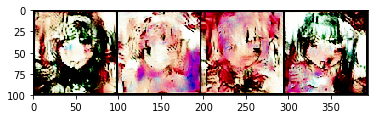

In [18]:
z = torch.randn(4, z_dimension).to(device)
images = g(z)
# save_image(images, 'xx.png')
plt.imshow(Image.fromarray(make_grid(images).mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy()))
plt.show()